<a href="https://colab.research.google.com/github/bbiggio/isde-test/blob/main/MNIST_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)

print(mnist.data.shape)

(70000, 784)


(70000, 784) (70000,)


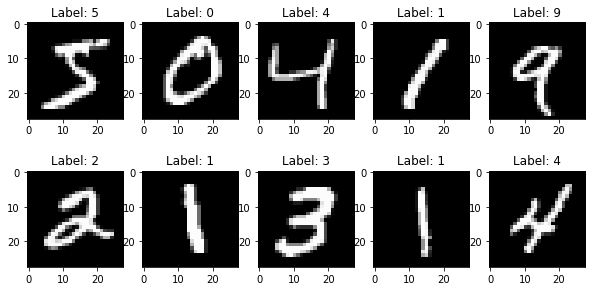

In [2]:
import numpy as np
import matplotlib.pyplot as plt


x = mnist.data / 255
y = np.array(mnist.target, dtype=int)

print(x.shape, y.shape)

# visualize first 10 images
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = x[i, :].reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.title("Label: " + str(y[i]))




<BarContainer object of 10 artists>

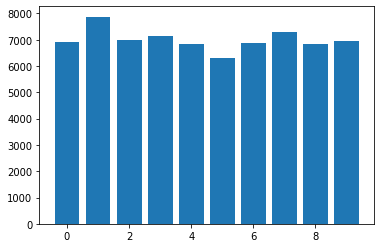

In [26]:
def samples_per_class(y):

    class_labels = np.unique(y)
    n_classes = class_labels.size

    # count how many elements we have in each class
    n_samples_per_class = np.zeros(shape=(n_classes,))

    # how many digits of class 'k' do we have among the 70K given images?
    for k in range(n_classes):
        n_samples_per_class[k] = np.sum(y == k)
    
    return n_samples_per_class, class_labels


n_samples_per_class, class_labels = samples_per_class(y)
plt.bar(class_labels, n_samples_per_class)




(50000, 784) (20000, 784) (50000,) (20000,)


<BarContainer object of 10 artists>

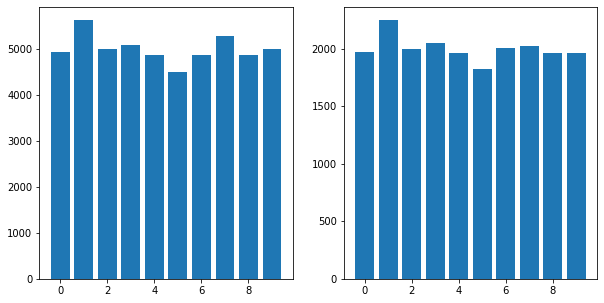

In [34]:
# data splits: goal is to split X,y into two disjoint sets.
n_tr = 50000
n_ts = 20000

# split_data: input X,y --> output X_tr, y_tr, X_ts, y_ts
#    input (0, 1, 2, 3, ... 69999) --> shuffle --> extract the first n_tr, n_ts -> output idx_tr, idx_ts

def split_data(x, y, n_tr, n_ts):

    n_samples = x.shape[0]
    idx = np.linspace(0, n_samples-1, num=n_samples, dtype=int)
    np.random.shuffle(idx)
    idx_tr = idx[:n_tr]
    idx_ts = idx[n_tr:n_tr+n_ts]

    x_tr = x[idx_tr, :]
    y_tr = y[idx_tr]
    x_ts = x[idx_ts, :]
    y_ts = y[idx_ts]
    return x_tr, y_tr, x_ts, y_ts


x_tr, y_tr, x_ts, y_ts = split_data(x, y, n_tr, n_ts)

print(x_tr.shape, x_ts.shape, y_tr.shape, y_ts.shape)

n_tr_samples_per_class, class_labels = samples_per_class(y_tr)
n_ts_samples_per_class, class_labels = samples_per_class(y_ts)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(class_labels, n_tr_samples_per_class)
plt.subplot(1,2,2)
plt.bar(class_labels, n_ts_samples_per_class)



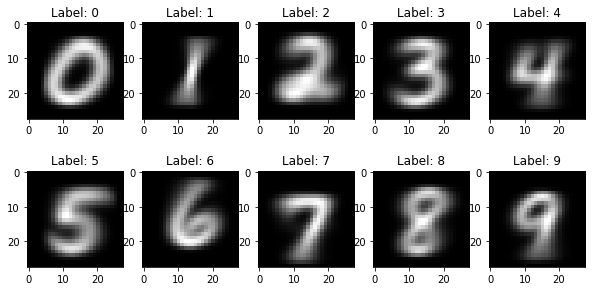

In [56]:
# we want to compute the average (centroid) image for each class (from the training set!)

# fit: x_tr, y_tr --> centroids (of shape = (10, 784))

def fit(x_tr, y_tr):
    n_classes = np.unique(y_tr).size  # count how many different elements we have in y_tr (should be 10)
    n_features = x_tr.shape[1]
    centroids = np.zeros(shape=(n_classes, n_features))

    for k in range(n_classes):
        # extract only images of 0 from x_tr
        xk = x_tr[y_tr==k, :]
        centroids[k, :] = np.mean(xk, axis=0)
    
    return centroids

centroids = fit(x_tr, y_tr)

# visualize the centroids
plt.figure(figsize=(10,5))
for k in range(n_classes):
    plt.subplot(2,5,k+1)
    plt.imshow(centroids[k,:].reshape(28,28), cmap='gray')
    plt.title("Label: " + str(k))



In [79]:
# Implementation of predict. 
# def predict(x_ts, centroids) --> y_pred
# 1. compute distances of test points against the centroids (distance matrix)
# 2. need to assign one predicted label to each test sample

n_ts_samples = x_ts.shape[0]
n_classes = centroids.shape[0]

dist = np.zeros(shape=(n_ts_samples, n_classes))
dist1 = np.zeros(shape=(n_ts_samples, n_classes))
print(dist.shape)

import time
from sklearn.metrics import pairwise_distances

# start_time = time.time()
# for i in range(n_ts_samples):
#    for k in range(n_classes):
#        dist[i,k] = np.sqrt(np.sum((x_ts[i,:]-centroids[k,:])**2))

# print(time.time()-start_time)

start_time = time.time()
# broadcasting to make this faster? (e.g. maybe saving one loop?)
for k in range(n_classes):
    dist1[:,k] = np.sqrt(np.sum((x_ts-centroids[k,:])**2, axis=1))

print(time.time()-start_time)

# print(dist-dist1)

start_time = time.time()

dist2 = pairwise_distances(x_ts, centroids)

print(time.time()-start_time)

m = np.argmin(dist2, axis=1)

print(dist2[:5, :])
print(m[:5])




def predict(x_ts, centroids):
    dist = pairwise_distances(x_ts, centroids)
    y_pred = np.argmin(dist, axis=1)
    return y_pred

y_pred = predict(x_ts, centroids)

print(np.mean(y_pred != y_ts))





(20000, 10)
0.540968656539917
0.07235312461853027
[[7.16448359 9.52155744 8.32289327 8.32493759 8.36797507 7.64182519
  6.26196727 9.1975319  8.13031495 8.23781993]
 [9.07956049 9.29761443 8.03761596 9.29295605 8.11850386 8.57568089
  6.28086281 9.1718313  8.48401348 8.4526041 ]
 [7.39935882 8.90389554 7.33178481 8.11107384 7.55250519 7.40687123
  7.80781774 8.37390607 7.71412134 8.03858488]
 [9.37302004 7.3874227  6.46475494 7.76480571 8.95107264 8.27271901
  7.42721587 9.06842332 7.852446   8.8072948 ]
 [8.41970966 8.90560528 8.20726504 8.99389144 5.62604752 7.67230184
  7.59667034 7.25725323 7.97199842 6.69881611]]
[6 6 2 2 4]
0.1914
